Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['StoxEurope', 'OBX_Energy', 'Q', 'Brent', 'dI_t', 'VIX', 'd_pi', 'EUR_NOK', 'OSEBX', 'SP500']

[info] Walk-forward VARX (daily panel) – Quarterly
       Periods       : 2000Q1 → 2025Q4 | n=104
       min_hist_days : 400
       max_var_lags  : 3
       n_jobs_outer  : -1, backend=loky

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter
  2000Q2: hist<400
  2000Q3: hist<400
  2000Q4: hist<400
  2001Q1: hist<400

=== VARX (daily panel) – Quarterly EUR/NOK performance ===
Observations: 99
RMSE (level): 0.240329
MAE  (level): 0.183766
Directional accuracy: 58/98 (59.2%)

=== Diebold–Mariano vs Random Walk (VARX daily panel, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -0.0909
p-value     : 0.9276


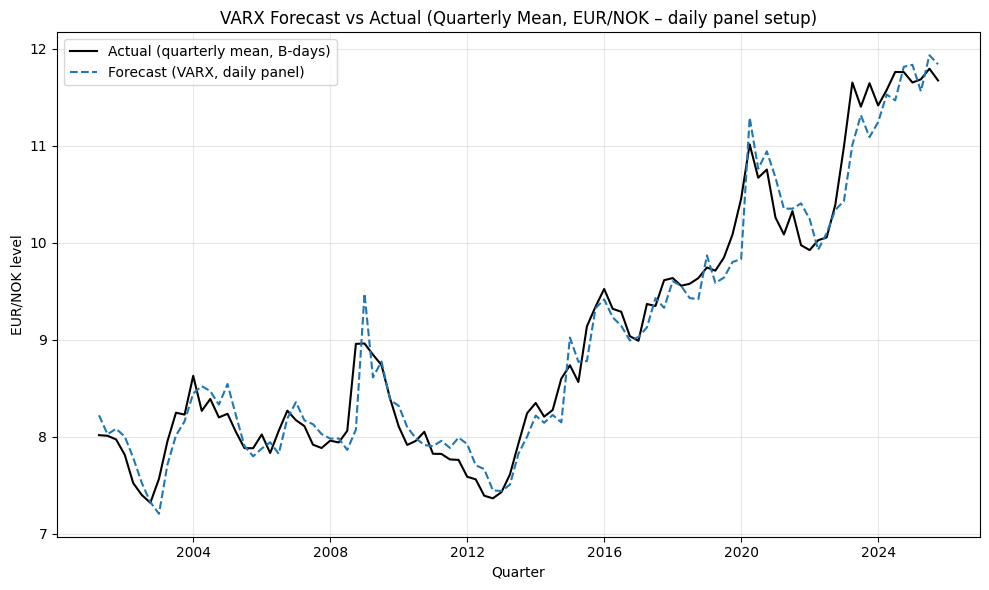

Saved: VARX_Q_daily_panel.png
Saved: VARX_Q_daily_panel.pdf


In [5]:
# =========================================
# VARX_Fx-Quarterly_panel_dailyVARX
# =========================================
# Panel VARX – EUR/NOK walk-forward (quarterly, levels)
# Daily panel, aligned with GB_Fx-Quarterly_panel:
#
#   - Target: EUR_NOK (evaluated quarterly)
#   - Endogenous block (VAR part):
#       EUR_NOK, Q, d_pi, dI_t
#   - Exogenous block (X part):
#       Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy
#
#   - Data: daily calendar days, forward-filled
#   - Cut: last business day of previous quarter (based on EUR_NOK business days)
#   - Forecast: daily next-quarter via VARX (frozen exog),
#       -> aggregate EUR/NOK to quarterly mean over business days
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed)
#   - PARALLEL OUTER LOOP over quarters
# =========================================

!pip -q install pandas numpy matplotlib requests certifi statsmodels scikit-learn joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"       # Quarterly evaluation, calendar quarters ending in Dec
    min_hist_days: int = 400    # Minimum daily history before first VARX estimation
    max_var_lags: int = 3       # Max daily VARX lag order (kept modest for stability)
    max_horizon: int = 128      # Must exceed longest quarter (~92 days)

    # Parallel settings
    n_jobs_outer: int = -1      # -1 = all cores
    backend: str = "loky"       # separate processes (safe for statespace models)

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "VARX_Q_daily_panel.png"
    fig_pdf: str = "VARX_Q_daily_panel.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Endogenous block: FX + macro
ENDOG_SERIES = [
    "EUR_NOK",
    "Q",
    "d_pi",
    "dI_t",
]

# Exogenous block: markets / risk sentiment
EXOG_SERIES = [
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]

ALL_COLS = ENDOG_SERIES + EXOG_SERIES


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV. Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX,
      StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill
             (for cuts and quarterly ground truth)
      DF_d : daily (D) wide DataFrame with ALL_COLS,
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ALL_COLS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in ALL_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR/NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# VARX lag order selection (daily)
# -----------------------------
def select_varx_lag(endog: pd.DataFrame, exog: pd.DataFrame, max_lags: int) -> int:
    """
    Select daily VARX lag order by looping over p=1..max_lags
    and choosing the model with the lowest AIC.

    Uses VARMAX(endog, exog, order=(p,0)).
    """
    best_p = 1
    best_aic = np.inf

    for p in range(1, max_lags + 1):
        # Need at least p+1 observations
        if len(endog) <= p + 1:
            continue
        try:
            model = VARMAX(
                endog,
                exog=exog,
                order=(p, 0),
                trend="c",
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False, maxiter=200)
            aic = res.aic
            if np.isfinite(aic) and aic < best_aic:
                best_aic = aic
                best_p = p
        except Exception as e:
            print(f"[warning] VARX lag selection failed for p={p}: {e}")
            continue

    best_p = max(1, min(best_p, max_lags, len(endog) - 1))
    return best_p


# -----------------------------
# Quarterly walk-forward using daily VARX
# PARALLEL outer loop
# -----------------------------
def walk_forward_varx_quarterly_daily_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky",
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit VARX on daily history up to cut:
          endog = [EUR_NOK, Q, d_pi, dI_t]
          exog  = [Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy]
      - forecast full next quarter at daily frequency (H calendar days) with
        exogenous paths frozen at last observed levels
      - aggregate EUR/NOK forecast to business-day quarterly mean and compare to truth
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    if CFG.verbose:
        print(f"\n[info] Walk-forward VARX (daily panel) – Quarterly")
        print(f"       Periods       : {quarters[0]} → {quarters[-1]} | n={len(quarters)}")
        print(f"       min_hist_days : {CFG.min_hist_days}")
        print(f"       max_var_lags  : {CFG.max_var_lags}")
        print(f"       n_jobs_outer  : {n_jobs_outer}, backend={backend}")

    def _process_one_quarter(q: pd.Period):
        """
        Inner worker: process one calendar quarter q.
        Returns:
          (quarter_str, row_dict_or_None, reason_or_None)
        """
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        # 1) Cut = last business day of previous quarter (same as GB)
        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        # 2) Daily history up to cut
        hist = DF_d.loc[:cut, ALL_COLS].copy()
        if hist.shape[0] < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        endog = hist[ENDOG_SERIES]
        exog  = hist[EXOG_SERIES]

        # 3) Business days inside target quarter (truth + aggregation base)
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # 4) Horizon = full calendar quarter length (inclusive) in calendar days
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        # 5) Fit daily VARX and forecast H steps with frozen exog
        try:
            p = select_varx_lag(endog, exog, max_lags=CFG.max_var_lags)

            model = VARMAX(
                endog,
                exog=exog,
                order=(p, 0),
                trend="c",
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False, maxiter=200)

            # Frozen exogenous path for forecast horizon:
            last_exog = exog.iloc[-1].to_numpy().reshape(1, -1)
            exog_fore = np.repeat(last_exog, H, axis=0)
            f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
            exog_fore = pd.DataFrame(exog_fore, index=f_idx, columns=EXOG_SERIES)

            # Forecast H steps ahead
            y_fore = res.forecast(steps=H, exog=exog_fore)
            y_fore.index = f_idx

        except Exception as e:
            return (str(q), None, f"varx_fit_fail({e})")

        # 6) Extract EUR_NOK forecast and aggregate to business-day mean
        if TARGET_SERIES not in y_fore.columns:
            return (str(q), None, "missing_target_in_forecast")

        pred_daily = y_fore[TARGET_SERIES]
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")

        y_pred = float(pred_b.dropna().mean())

        row = {
            "quarter": q,
            "cut": cut,
            "lag_order": p,
            "y_true": y_true,
            "y_pred": y_pred,
        }
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy for quarterly EUR/NOK."""
    df = eval_df.copy()
    if df.empty:
        print("\nNo evaluation data.")
        return df

    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== VARX (daily panel) – Quarterly EUR/NOK performance ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous quarter's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (VARX daily panel, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (VARX, daily panel)"
    )

    plt.title("VARX Forecast vs Actual (Quarterly Mean, EUR/NOK – daily panel setup)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data (aligned with GB quarterly code)
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Quarterly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_varx_quarterly_daily_parallel(
        S_b, DF_d,
        n_jobs_outer=CFG.n_jobs_outer,
        backend=CFG.backend,
    )
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

    return {
        "S_b": S_b,
        "DF_d": DF_d,
        "eval_quarterly": eval_df,
    }


if __name__ == "__main__":
    results = main()
